Example taken from https://www.kaggle.com/fatmakursun/pyspark-ml-tutorial-for-beginners

Dataset from https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

In [ ]:
!wget https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz -P data/cal_housing/

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [5]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [16]:
# Load housing data
housing_path='data/cal_housing/CaliforniaHousing/cal_housing.data'
housing_df = spark.read.csv(path=housing_path, schema=schema).cache()
#spark.read.csv(path=housing_path).printSchema()
#spark.read.text(housing_path).show(truncate=False)

# Exploratory Analysis

In [17]:
housing_df.show()

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|269700.0|
|-122.25|37.84|  52.0|  2535.0|   489.0|1094.0|   514.0|3.6591|299200.0|
|-122.25|37.84|  52.0|  3104.0|   687.0|1157.0|   647.0|  3.12|241400.0|
|-122.26|37.84|  42.0|  2555.0|   665.0|1206.0|   595.0|2.0804|226700.0|
|-122.25|37.84|  52.0|  3549.0|   707.0|1551.0|   714.0|3.6912|261100.0|
|-122.26|37.85|  52.0|  2202.0|   434.0| 910.0|   4

In [21]:
housing_df.summary().toPandas()

,summary,long,lat,medage,totrooms,totbdrms,pop,houshlds,medinc,medhv
0,count,20640,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,-119.56970444871473,35.63186143109965,28.639486434108527,2635.7630813953488,537.8980135658915,1425.4767441860465,499.5396802325581,3.8706710030346416,206855.81690891474
2,stddev,2.003531742932898,2.135952380602968,12.58555761211163,2181.6152515827944,421.247905943133,1132.46212176534,382.3297528316098,1.8998217183639696,115395.61587441359
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0
4,25%,-121.8,33.93,18.0,1447.0,295.0,787.0,280.0,2.5625,119600.0
5,50%,-118.49,34.26,29.0,2127.0,435.0,1166.0,409.0,3.5347,179700.0
6,75%,-118.01,37.71,37.0,3146.0,647.0,1724.0,605.0,4.7426,264700.0
7,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0


In [22]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



In [23]:
# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



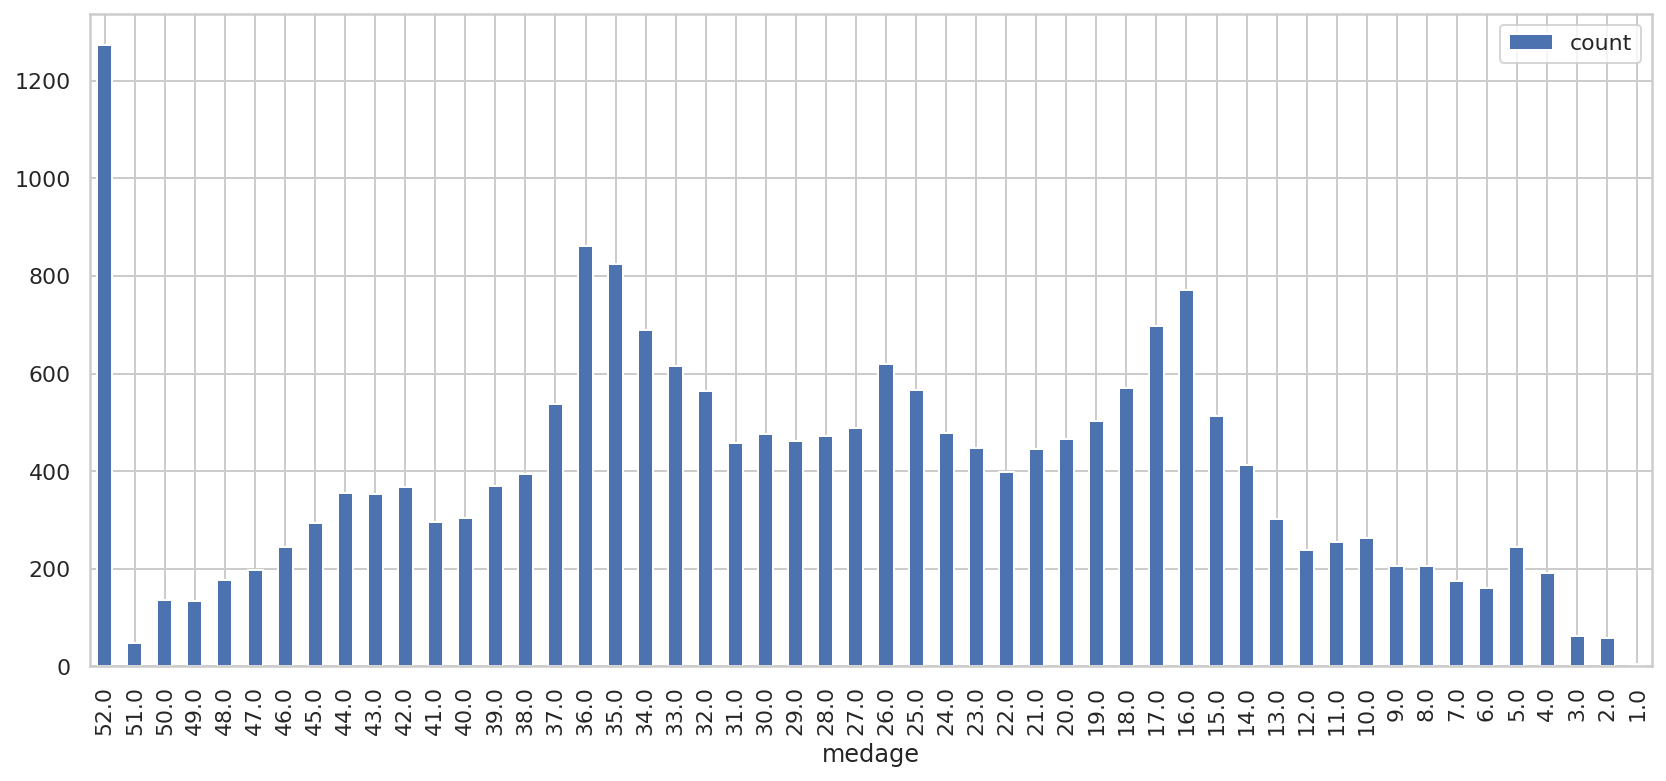

In [24]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

# Data preparation

In [27]:
reformated_df = housing_df[housing_df.medage>6]

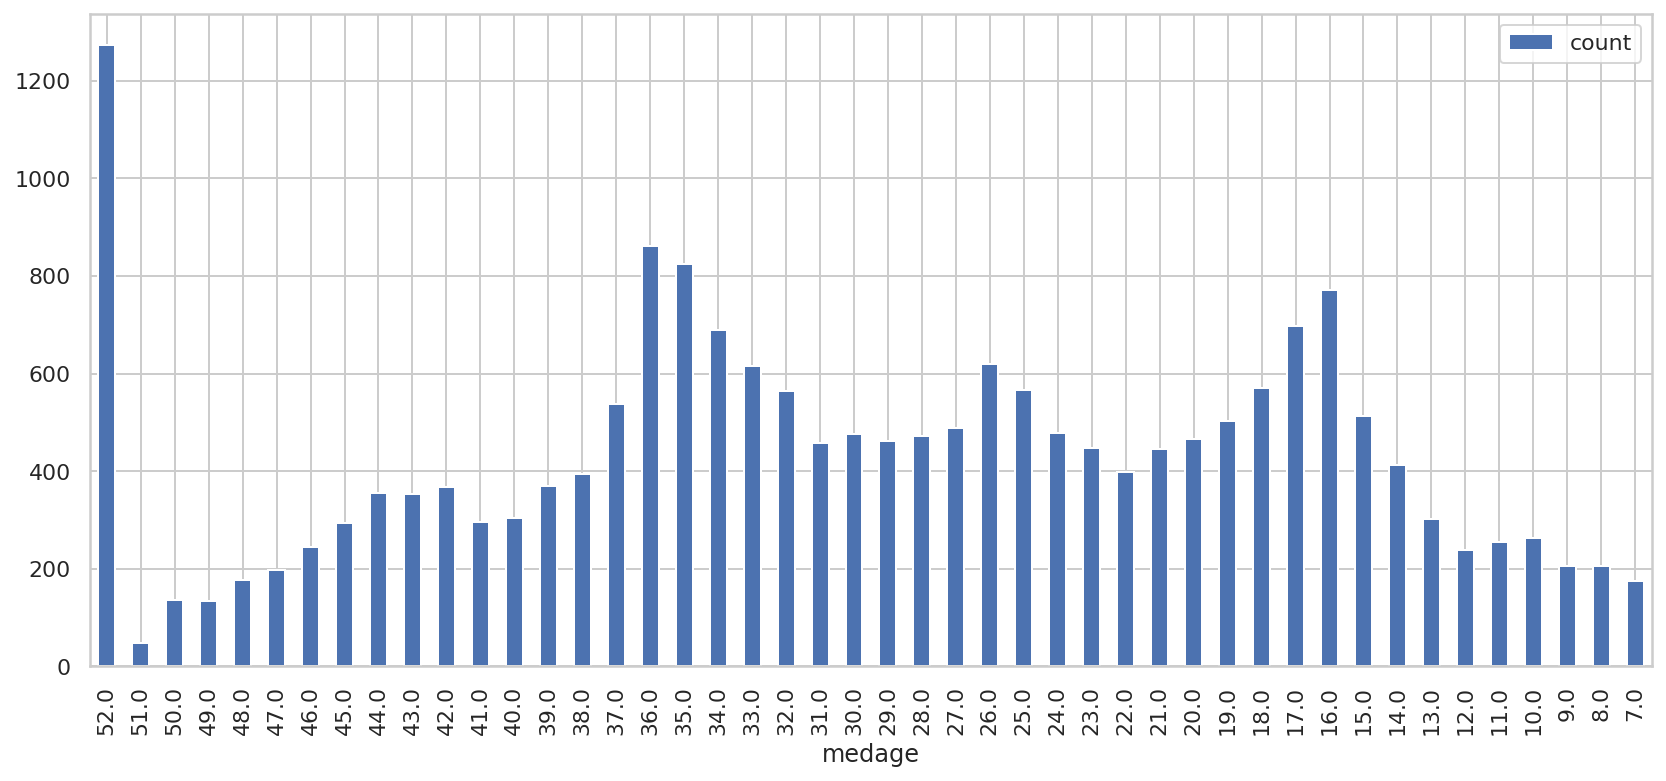

In [28]:
reformated_df.groupBy("medage").count().sort("medage", ascending=False).toPandas().plot.bar(x='medage',figsize=(14, 6))

In [29]:
# Adjust the values of `medianHouseValue`
reformated_df = reformated_df.withColumn("medhv", col("medhv")/100000)

In [30]:
reformated_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



In [31]:
# Add the new columns to `df`
reformated_df = (reformated_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [32]:
# Inspect the result
reformated_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



In [33]:
# Re-order and select columns
reformated_df = reformated_df.select("medhv", 
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

In [34]:
reformated_df.show(5)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 5 rows



In [35]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

In [36]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [37]:
type(assembler)

pyspark.ml.feature.VectorAssembler

In [38]:
assembled_df = assembler.transform(reformated_df)

In [39]:
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


In [40]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [41]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [42]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                         |
+-------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.33437251419785585,0.30664126709769485,0.3561499621807239,4.407092235211415,2.8127756791070193,0.24252430048514179,2.5922581379035545]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.866790703122702,2.2864772742284636,3.2166560076322526,4.394493338259958,2.514573099946676,0.19989307579048793,2.765075347097125]     |
|[190.0,496.0,177.0,7.257

# Build and train a model

In [102]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

In [61]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [104]:
# Fit the data to the model
linearModel = lr.fit(train_data)
type(linearModel)

pyspark.ml.regression.LinearRegressionModel

In [63]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.53, 0.0, 0.0, 0.0])

In [64]:
# Intercept for the model
linearModel.intercept

0.9839810901369285

# Predictions

In [54]:
test_data.show()

+-----+--------+-------+--------+------+--------+--------+----------+--------------------+--------------------+
|medhv|totbdrms|    pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|            features|     features_scaled|
+-----+--------+-------+--------+------+--------+--------+----------+--------------------+--------------------+
|0.269|   543.0| 1423.0|   482.0|2.1955|     5.7|    2.95|       0.2|[543.0,1423.0,482...|[1.40747500162353...|
|0.275|    24.0|   29.0|    15.0|1.2656|    6.47|    1.93|      0.25|[24.0,29.0,15.0,1...|[0.06220883985076...|
|0.283|  3114.0|12427.0|  2826.0|2.7377|    6.28|     4.4|      0.18|[3114.0,12427.0,2...|[8.07159697063661...|
|0.325|   422.0| 1055.0|   382.0|1.8519|    2.65|    2.76|      0.42|[422.0,1055.0,382...|[1.09383876737593...|
|0.344|   121.0|  530.0|   115.0|2.1458|    3.08|    4.61|      0.34|[121.0,530.0,115....|[0.31363623424760...|
|0.379|   756.0| 1798.0|   749.0|  1.75|    4.21|     2.4|      0.24|[756.0,1798.0,749...|[1.95957845529

In [65]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [59]:
predictions.show()

+-----+--------+-------+--------+------+--------+--------+----------+--------------------+--------------------+------------------+
|medhv|totbdrms|    pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|            features|     features_scaled|         predmedhv|
+-----+--------+-------+--------+------+--------+--------+----------+--------------------+--------------------+------------------+
|0.269|   543.0| 1423.0|   482.0|2.1955|     5.7|    2.95|       0.2|[543.0,1423.0,482...|[1.40747500162353...| 1.516890509641724|
|0.275|    24.0|   29.0|    15.0|1.2656|    6.47|    1.93|      0.25|[24.0,29.0,15.0,1...|[0.06220883985076...|1.1943961102103042|
|0.283|  3114.0|12427.0|  2826.0|2.7377|    6.28|     4.4|      0.18|[3114.0,12427.0,2...|[8.07159697063661...| 1.859342260424021|
|0.325|   422.0| 1055.0|   382.0|1.8519|    2.65|    2.76|      0.42|[422.0,1055.0,382...|[1.09383876737593...| 1.471801840363564|
|0.344|   121.0|  530.0|   115.0|2.1458|    3.08|    4.61|      0.34|[121.0,530.0,1

In [66]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [67]:
predandlabels.show()

+------------------+-----+
|         predmedhv|medhv|
+------------------+-----+
| 1.599917140410915|0.269|
| 1.339038562642064|0.275|
|1.7520285485805758|0.283|
|1.5035219754103748|0.325|
|1.5859741252996056|0.344|
|1.4749344668375053|0.379|
|1.5287148973082914|0.388|
|1.3567970514384773|0.394|
|1.6963123388549999|  0.4|
| 2.018489991041715|  0.4|
|1.3647084229310615| 0.41|
|1.4498818071660942|0.421|
|  1.35803145267365|0.425|
|1.7779228150545638| 0.43|
|1.4857354274799517|0.435|
|1.3220095109992773| 0.44|
|1.5853007729704542| 0.44|
|1.3564884678514564|0.445|
|1.4639651513909986|0.446|
|1.8040415546006323| 0.45|
+------------------+-----+
only showing top 20 rows



In [58]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8664994758035244


In [60]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.44919324499584923


In [73]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

R2: 0.4145004237710719


In [69]:
grid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.4, 0.6, 1.0]) \
    .build()

In [71]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

In [72]:
cvModel = cv.fit(test_data)

In [75]:
cvModel.bestModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5931, 0.0, 0.0, 0.0])

In [76]:
predictions = cvModel.bestModel.transform(test_data)

In [77]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

R2: 0.4374742149554388


# Build Pipeline

In [79]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline, PipelineModel

In [80]:
sqlTrans = SQLTransformer(statement="""
SELECT
medhv/100000 as medhv,
totbdrms, pop, houshlds, medinc, 
round(totrooms/houshlds,2) as rmsperhh,
round(pop/houshlds,2) as popperhh,
round(totbdrms/totrooms,2) as bdrmsperrm
FROM __THIS__"""
)

In [81]:
reformated_df = sqlTrans.transform(housing_df)
reformated_df.show(10)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|
|2.697|   213.0| 413.0|   193.0|4.0368|    4.76|    2.14|      0.23|
|2.992|   489.0|1094.0|   514.0|3.6591|    4.93|    2.13|      0.19|
|2.414|   687.0|1157.0|   647.0|  3.12|     4.8|    1.79|      0.22|
|2.267|   665.0|1206.0|   595.0|2.0804|    4.29|    2.03|      0.26|
|2.611|   707.0|1551.0|   714.0|3.6912|    4.97|    2.17|       0.2|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 10 rows



In [82]:
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [83]:
assembled_df = assembler.transform(reformated_df)
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


In [84]:
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [85]:
scaler_model = standardScaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)
scaled_df.select('features', 'features_scaled').show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

In [98]:
#transform_pipeline=PipelineModel(stages=[sqlTrans, assembler])
#transform_pipeline=PipelineModel(stages=[sqlTrans, assembler, scaler_model])
transform_pipeline=Pipeline(stages=[sqlTrans, assembler, standardScaler])
#transform_pipeline=PipelineModel(stages=[sqlTrans, assembler, scaler_model])
#transform_pipeline = pipeline.transform(housing_df)
transform_pipeline

Pipeline_f6431985947c

In [99]:
transform_pipeline.fit(housing_df)

PipelineModel_5cc53353d87e

In [95]:
#transform_pipeline.fit(housing_df).transform(housing_df).select('features', 'features_scaled').show(10, truncate=False)
transform_pipeline.transform(housing_df).select('features', 'features_scaled').show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

In [96]:
#pipeline = Pipeline(stages=[sqlTrans, assembler, standardScaler, lr])
pipeline = Pipeline(stages=[sqlTrans, assembler, scaler_model, lr])

In [105]:
train_data, test_data = housing_df.randomSplit([.8,.2], seed=rnd_seed)

In [106]:
linModel = pipeline.fit(train_data)

In [107]:
predictions = linModel.transform(test_data)
predictions.select("predmedhv", "medhv").show(10)

+------------------+-----+
|         predmedhv|medhv|
+------------------+-----+
|1.5542767583900856|0.669|
| 1.713460445247065|0.684|
| 1.979684827774791|0.901|
|1.5969316612081879| 0.67|
| 1.801469239698214|0.864|
|1.4367462604245609|0.755|
| 2.040731728995508|1.094|
| 1.803695167452832| 0.82|
|1.4903917893314298|0.769|
|1.6236152637152896|0.927|
+------------------+-----+
only showing top 10 rows



In [108]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predictions)))

RMSE: 0.8647815196218862


In [109]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions)))

R2: 0.4239687132175256
